
# Genetikus algoritmusok – **Szelekciós módszerek** (HU)

Ebben a jegyzetben a leggyakoribb szelekciós eljárásokat fogjuk gyakorolni:

- **Fitness arányos (rulettkerék)**
- **Tournament szelekció (k-fős verseny)**
- **Rang alapú szelekció**
- **Elitizmus**

Házi feladat extra pontokért:

- **Boltzmann / sztochasztikus szelekció** (Bónusz feladat)
- **Truncation (csonkolás)** (Bónusz feladat)


**Labor célja:** az evolúciós nyomás és diverzitás **egyensúlyának** bemutatása, valamint a módszerek **előnyeinek / hátrányainak** megértése.


In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
random.seed(7)
np.random.seed(7)



## 0) Oktatási minta-populáció

Az alábbi **kis populáció** segít szemléltetni a módszerek viselkedését. A fitness értékeket úgy választjuk, hogy legyenek **extrém különbségek** is (hogy lássuk a torzító hatást).

- Populáció méret: `N = 10`
- Fitness: néhány nagyon jó, több közepes, és 1–2 gyenge egyed


In [2]:

# Minta-populáció (azonosítók és fitness)
N = 10
ids = np.array([f"ind_{i}" for i in range(N)])

# Kézzel beállított, szemléltető fitnessek (extrém különbségekkel)
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

# Normalizáló segédfüggvények
def normalize_positive(x):
    # Eltolás, hogy minden érték >= 0 legyen
    m = np.min(x)
    if m < 0:
        x = x - m
    return x

def softmax_scaled(x, T=1.0):
    # Boltzmann valószínűségek: exp(x/T) normalizálva (numerikusan stabil)
    z = (x - np.max(x)) / max(T, 1e-8)
    e = np.exp(z)
    return e / np.sum(e)

print("Egyedek:", ids)
print("Fitness :", fitness)


Egyedek: ['ind_0' 'ind_1' 'ind_2' 'ind_3' 'ind_4' 'ind_5' 'ind_6' 'ind_7' 'ind_8'
 'ind_9']
Fitness : [ 2.   5.   1.  30.   4.   3.  18.   0.5  8.   0.2]


In [3]:

def plot_selection_counts(ids, counts, title):
    # Egyszerű oszlopdiagram: kiválasztási gyakoriságok
    plt.figure()
    x = np.arange(len(ids))
    plt.bar(x, counts)
    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(title)
    plt.tight_layout()
    plt.show()



## 1) Fitness arányos szelekció (rulettkerék)

**Ötlet:** az egyed kiválasztási valószínűsége arányos a fitness értékével.  
- **Előny:** egyszerű, intuitív.  
- **Hátrány:** **extrém** fitness különbségeknél **eltorzul**, a legjobb(ak) dominál(nak), **diverzitás csökkenhet**.

> Megjegyzés: negatív fitness esetén eltolást/normalizálást kell alkalmazni.


Rulettkerék valószínűségek (≈):
ind_0: p≈0.028
ind_1: p≈0.070
ind_2: p≈0.014
ind_3: p≈0.418
ind_4: p≈0.056
ind_5: p≈0.042
ind_6: p≈0.251
ind_7: p≈0.007
ind_8: p≈0.112
ind_9: p≈0.003


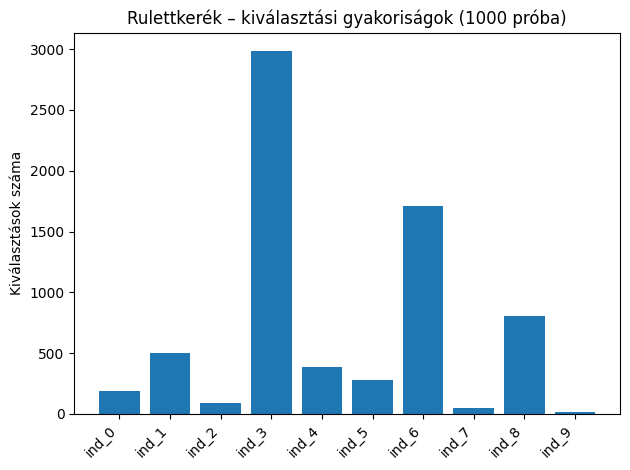

In [4]:

def roulette_wheel_selection(ids, fitness, n_select):
    f = normalize_positive(fitness.astype(float))
    total = np.sum(f)
    if total <= 0:
        # ha minden 0, uniform választás
        p = np.ones_like(f) / len(f)
    else:
        p = f / total
    # mintavétel visszatevéssel
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p

# Illusztráció: ismételt kiválasztások és gyakoriság diagram
n_trials = 7000
selected, probs = roulette_wheel_selection(ids, fitness, n_trials)
unique, counts = np.unique(selected, return_counts=True)

print("Rulettkerék valószínűségek (≈):")
for i, id_ in enumerate(ids):
    print(f"{id_}: p≈{probs[i]:.3f}")

# Grafikon
count_map = {u:c for u,c in zip(unique, counts)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])
plot_selection_counts(ids, counts_ordered, "Rulettkerék – kiválasztási gyakoriságok (1000 próba)")



## 2) Tournament szelekció (k-fős verseny)

**Ötlet:** minden kiválasztáshoz véletlenszerűen választunk `k` egyedet, és **közülük a legjobb** nyer.  
- **Előny:** **gyors**, **skálázható**, ritkábban zuhan túlzott szelekciós nyomásba.  
- **Paraméter:** a `k` növelése erősíti a szelekciós nyomást (kicsi `k` → több diverzitás).


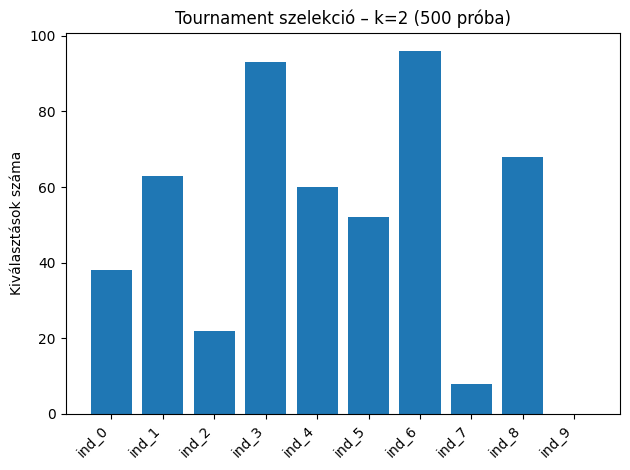

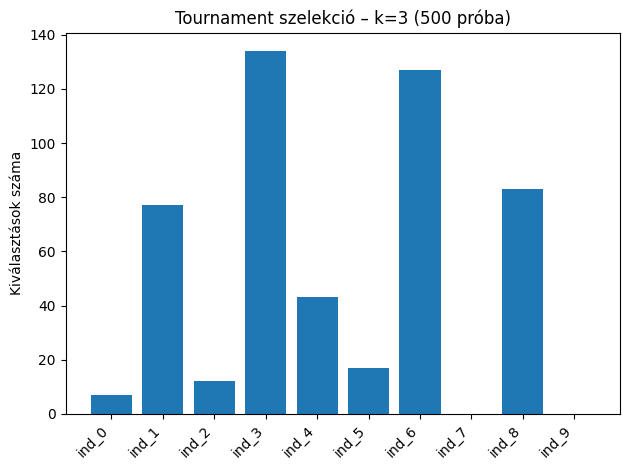

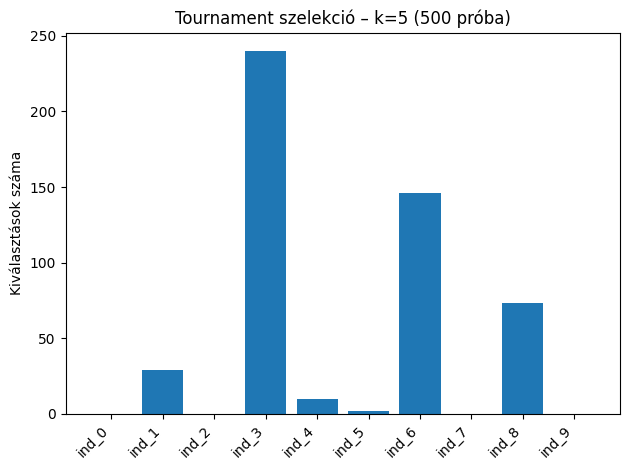

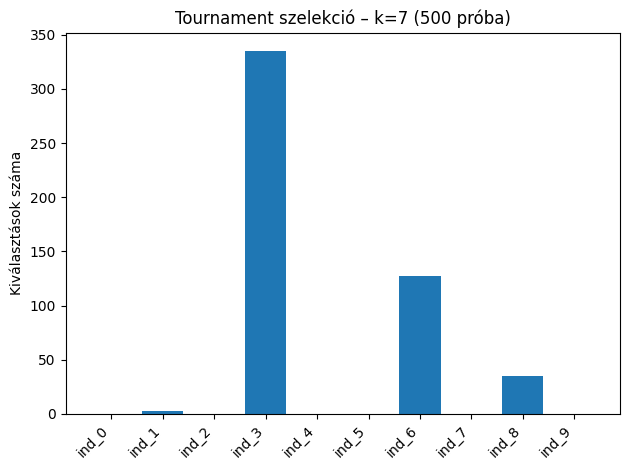

In [5]:

def tournament_selection(ids, fitness, n_select, k=4):
    chosen = []
    for _ in range(n_select):
        idxs = np.random.choice(len(ids), size=k, replace=False)
        best_idx = idxs[np.argmax(fitness[idxs])]
        chosen.append(ids[best_idx])
    return np.array(chosen)

# Hasonlítsuk össze különböző k értékekkel
for k in [2, 3, 5, 7]:
    n_trials = 500
    sel = tournament_selection(ids, fitness, n_trials, k=k)
    uniq, cnt = np.unique(sel, return_counts=True)
    count_map = {u:c for u,c in zip(uniq, cnt)}
    counts_ordered = np.array([count_map.get(i, 0) for i in ids])
    plot_selection_counts(ids, counts_ordered, f"Tournament szelekció – k={k} (500 próba)")



## 3) Rang alapú szelekció

**Ötlet:** az egyedeket **rangsoroljuk** fitness szerint, és a kiválasztási esély a **ranghoz kötött**.  
- **Előny:** stabilizálja a szelekciót, **ellenálló** extrém fitness különbségeknél is (nem engedi túl-dominálni a csúcs értékeket).  
- **Megvalósítás:** pl. lineáris rangsúlyozás – a legjobb rang kapja a legnagyobb valószínűséget, de arányok kontrolláltak.


Rangsúlyok (legnagyobb a legjobb): [ 4  7  3 10  6  5  9  2  8  1]
Rang alapú valószínűségek (≈): [0.073 0.127 0.055 0.182 0.109 0.091 0.164 0.036 0.145 0.018]


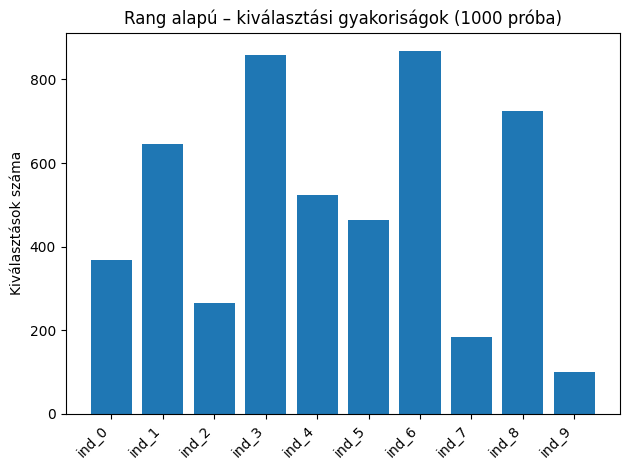

In [6]:

def rank_based_selection(ids, fitness, n_select):
    # Rangsorolás (nagyobb fitness -> jobb rang)
    order = np.argsort(-fitness)  # desc
    ranks = np.empty_like(order)
    ranks[order] = np.arange(len(ids), 0, -1)  # legjobb kapja a legnagyobb rangszámot

    # Lineáris valószínűség a ranghoz arányosan
    p = ranks / np.sum(ranks)
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p, ranks

n_trials = 5000
selected, p_rank, ranks = rank_based_selection(ids, fitness, n_trials)
uniq, cnt = np.unique(selected, return_counts=True)
count_map = {u:c for u,c in zip(uniq, cnt)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])

print("Rangsúlyok (legnagyobb a legjobb):", ranks)
print("Rang alapú valószínűségek (≈):", np.round(p_rank, 3))
plot_selection_counts(ids, counts_ordered, "Rang alapú – kiválasztási gyakoriságok (1000 próba)")



## 4) Elitizmus

**Ötlet:** a **legjobb** `E` egyed **garantáltan** átkerül a következő generációba.  
- **Előny:** a **legjobb megoldás** nem vész el.  
- **Hátrány:** túl erős elitizmus → **diverzitás csökken**, **lokális optimumhoz ragadhat**.

Az alábbi példa egyetlen generációt illusztrál: először elit másolás, majd a maradék helyek feltöltése (pl. rang alapú szelekcióval).


In [7]:

def elite_preservation(ids, fitness, E=2):
    # top-E indexek
    order = np.argsort(-fitness)
    elites = ids[order[:E]]
    return elites

def next_generation_with_elite(ids, fitness, pop_size=10, E=3):
    elites = elite_preservation(ids, fitness, E=E)
    remaining = pop_size - E
    selected, _, _ = rank_based_selection(ids, fitness, remaining)
    # új generáció (azonosítók szintjén bemutatva)
    new_gen = np.concatenate([elites, selected])
    return new_gen

new_gen = next_generation_with_elite(ids, fitness, pop_size=10, E=2)
print("Elitek:", elite_preservation(ids, fitness, E=2))
print("Új generáció (azonosítók):", new_gen)


Elitek: ['ind_3' 'ind_6']
Új generáció (azonosítók): ['ind_3' 'ind_6' 'ind_2' 'ind_6' 'ind_1' 'ind_5' 'ind_3' 'ind_5' 'ind_6'
 'ind_1']



## 5) Boltzmann / sztochasztikus szelekció

**Ötlet:** valószínűségek **hőmérsékletfüggők** – `p_i ∝ exp(fitness_i / T)`  
- **Magas T:** közel **egyenletes** kiválasztás → **nagy diverzitás**.  
- **Alacsony T:** a nagy fitness **dominál** → **erős nyomás**.

Gyakori stratégia: **hűtés** (T fokozatos csökkentése).



## 6) Truncation (csonkolás) szelekció

**Ötlet:** csak a **legjobb** `p%` kerülhet tovább, a többiek kiesnek.  
- **Előny:** **nagyon erős** szelekciós nyomás, gyors konvergencia.  
- **Hátrány:** **diverzitás** gyors elvesztése, könnyebb **lokális optimum**.

Az alábbi implementáció a top `p%` halmazból választ **visszatevéssel** (ha a populációt ugyanarra a méretre akarjuk feltölteni).



## 7) Kérdések és rövid, gyakorlati válaszok

**Mi a különbség a rulettkerék- és a tournament-szelekció között?**  
- Rulettkerék: valószínűség **arányos** a fitness-szel → **extrém értékek torzíthatnak**.  
- Tournament: mindig **k** jelölt versenyez, a **legjobb nyer** → paraméterezhető nyomás, **skálázható** és robusztusabb extrémekkel szemben.

**Miért előnyös a rang alapú szelekció extrém fitness különbségek esetén?**  
- Mert a kiválasztási esélyt **nem a nyers fitness**, hanem a **rang** határozza meg → **stabilabb**, nem engedi a túl-dominanciát.

**Milyen előnye és hátránya van az elitizmusnak?**  
- Előny: a **legjobb megoldás** nem vész el, **monoton** javulás biztosítható.  
- Hátrány: túl nagy elit arány → **diverzitás** csökken, **beszorulás** lokális optimumba.

**Mely szelekciós módszer illik legjobban a permutációs ábrázoláshoz?**  
- Gyakorlati tapasztalat szerint a **tournament** és **rang alapú** jól működik permutációknál, mert **robosztusabbak** az outlierekkel szemben és jól **skálázódnak**.

**Miért engednek néha a gyengébb egyedeknek is esélyt a szelekcióban?**  
- A **diverzitás** fenntartása miatt: a túl erős nyomás **korai konvergenciához** vezethet. Némi véletlen esély segít elkerülni a **lokális optimumot** és támogatja a **feltárást**.


# Szelekciós módszerekhez gyakorló feladatok
Ez a notebook a szelekciós módszerekhez és deceptív függvényekhez kapcsolódó gyakorlófeladatokat tartalmazza.

## 1. Feladat – Rulettkerék valószínűségek
Számold ki a rulettkerekes kiválasztási valószínűségeket.
Az ids és fitness tömbök alapján:



1.   Számold ki a fitness-ek összegét.
2.   Számold ki minden egyed rulettkerekes kiválasztási valószínűségét:

$$
p_i = \frac{f_i}{\sum_j f_j}
$$


2.   Add meg, melyik egyedé a legnagyobb és a legkisebb valószínűség.

Megjegyzés: elég 3-4 tizedesig kerekíteni.

In [10]:
import numpy as np

ids = ['X', 'Y', 'Z', 'A', 'B']
fitness = [15.0, 70.0, 5.0, 30.0, 2.0]

total_fitness = np.sum(fitness)

if total_fitness <= 0:
    probabilities = np.ones_like(fitness) / len(fitness)
else:
    probabilities = fitness / total_fitness

print("Rulettkerék kiválasztási valószínűségek (saját értékekkel):")
for i, (id_, prob) in enumerate(zip(ids, probabilities)):
    print(f"{id_}: p={prob:.4f}")

max_prob_idx = np.argmax(probabilities)
min_prob_idx = np.argmin(probabilities)

print(f"\nLegnagyobb valószínűségű egyed: {ids[max_prob_idx]} (p={probabilities[max_prob_idx]:.4f})")
print(f"Legkisebb valószínűségű egyed: {ids[min_prob_idx]} (p={probabilities[min_prob_idx]:.4f})")

Rulettkerék kiválasztási valószínűségek (saját értékekkel):
X: p=0.1230
Y: p=0.5738
Z: p=0.0410
A: p=0.2459
B: p=0.0164

Legnagyobb valószínűségű egyed: Y (p=0.5738)
Legkisebb valószínűségű egyed: B (p=0.0164)


## 2. Feladat – Tournament szelekció (k=3)
Véletlenszerűen válassz 3 különböző egyedet, indexet 0 és 9 között (pl. 2, 4, 6) a populációból.

1.   Írd fel, mely egyedek kerültek a tournament-be (ind_2, ind_4, ind_6) és mi a fitness-ük.
2.   Döntsd el, ki nyer a tournament-ben (ki kerül kiválasztásra).
3.   Röviden írd le: miért mondjuk, hogy a tournament szelekció „erősebb szelekciós nyomást” tud adni, mint a rulettkerék?

In [11]:
import numpy as np
import random

N = 10
ids = np.array([f"id_{i}" for i in range(N)])
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

k = 3
population_size = len(ids)

selected_indices = np.random.choice(population_size, size=k, replace=False)

tournament_ids = ids[selected_indices]
tournament_fitness = fitness[selected_indices]

print(f"Tournamentbe került egyedek (k={k}):")
for i in range(k):
    print(f"  - Azonosító: {tournament_ids[i]}, Fitness: {tournament_fitness[i]}")

winner_idx_in_tournament = np.argmax(tournament_fitness)
winner_id = tournament_ids[winner_idx_in_tournament]
winner_fitness = tournament_fitness[winner_idx_in_tournament]

print(f"\nA tournament nyertese: {winner_id} (Fitness: {winner_fitness})")

Tournamentbe került egyedek (k=3):
  - Azonosító: id_4, Fitness: 4.0
  - Azonosító: id_3, Fitness: 30.0
  - Azonosító: id_9, Fitness: 0.2

A tournament nyertese: id_3 (Fitness: 30.0)


Miért adhat a tournament szelekció "erősebb szelekciós nyomást", mint a rulettkerék? Egyszerűen azért, mert:

*  **Direkt verseny van**: Gondolj bele, mint egy kisebb bajnokságba: a tournamentben egyből egymásnak esnek az egyedek, és aki a legfittebb, az tuti nyer. Nincs mese! A rulettkeréknél viszont még a gyengébbek is kaphatnak egy kis esélyt, ha valamennyire pozitív a fitnessük. Szóval ott nem ennyire egyértelmű, hogy csak a szuperjó jut tovább.

* **A 'k' számmal lehet játszani**: Ez a 'k' paraméter (ami a tournament méretét jelöli) mondja meg, mennyire legyen kemény a szelekció. Minél nagyobb a 'k', annál nagyobb a nyomás! Ha sokan vannak a miniversenyen, valószínűbb, hogy bekerül oda egy eszméletlenül jó egyed, és akkor őt választják ki. Ha meg gigantikus a 'k', akkor szinte mindig a legeslegjobb fog nyerni. Ezt a rulettkerék nem feltétlenül garantálja, még akkor sem, ha van egy kiugróan jó egyed.

Szóval ez a módszer jobban bírja az extrém fitness értékeket, és segít megakadályozni, hogy egyetlen szuperzseni egyed mindent visz. De alapvetően tényleg jobban ráhajt a jókra, mint a rulettkerék, különösen, ha nagyobb 'k'-val dolgozunk.

## 3. Feladat – Rang alapú szelekció
Rangsorolás és vizsgálat.


1.   Rendezd a populációt fitnesz szerint csökkenő sorrendbe.
2.   Adj mindenkinek rangot (1 = legjobb, 10 = legrosszabb).
3.   Írd fel a (id, fitness, rang) hármast egy kis táblázatba.
4.   Magyarázd meg 2 mondatban, miért kevésbé érzékeny a rang alapú szelekció az extrém fitness értékekre, mint a rulettkerék.

In [12]:
import numpy as np

N = 10
ids = np.array([f"ind_{i}" for i in range(N)])
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

order = np.argsort(-fitness)
sorted_ids = ids[order]
sorted_fitness = fitness[order]

ranks = np.arange(1, len(ids) + 1)

assigned_ranks = np.zeros_like(fitness, dtype=int)
for i, idx in enumerate(order):
    assigned_ranks[idx] = i + 1

sorted_ranks_for_display = assigned_ranks[order]

print("Rang alapú szelekció eredménye (rendezve fitness szerint):")
print("--------------------------------------------------")
print(f"{'Azonosító':<10} {'Fitness':<10} {'Rang':<5}")
print("--------------------------------------------------")
for i in range(len(ids)):
    print(f"{sorted_ids[i]:<10} {sorted_fitness[i]:<10.1f} {sorted_ranks_for_display[i]:<5}")
print("--------------------------------------------------")

Rang alapú szelekció eredménye (rendezve fitness szerint):
--------------------------------------------------
Azonosító  Fitness    Rang 
--------------------------------------------------
ind_3      30.0       1    
ind_6      18.0       2    
ind_8      8.0        3    
ind_1      5.0        4    
ind_4      4.0        5    
ind_5      3.0        6    
ind_0      2.0        7    
ind_2      1.0        8    
ind_7      0.5        9    
ind_9      0.2        10   
--------------------------------------------------


A rang alapú szelekció azért kevésbé érzékeny az extrém fitness értékekre, mint a rulettkerék, mert nem a nyers fitneszértékek abszolút nagyságára, hanem azok relatív sorrendjére épül.

Ezáltal egy kiugróan magas fitneszű egyed nem tudja aránytalanul kisajátítani a kiválasztási valószínűségek nagy részét, mert a rangja csak egyet javul a következő legjobbhoz képest, nem pedig a fitnesz különbségével arányosan nő. Ezzel stabilizálja a szelekciós nyomást és segít fenntartani a diverzitást.

## 4. Feladat (közepes) – Rulettkerék vs Tournament (10 000 futás)
Hasonlítsd össze a gyakoriságokat. Írj egy rövid Python-kódot, amely:

1.   A notebook-ban korábban definiált ids, fitness tömböt használd.
2.   10 000-szer kiválasztunk:
  - (a) rulettkerékkel,
  - (b) 3-fős tournament-tel.
3.   Külön-külön számold ki, hogy hányszor lett kiválasztva minden egyed.
4.   Ábrázold oszlopdiagramon:
 - x tengely: ind_0 … ind_9
 - y tengely: kiválasztási gyakoriság.
5.   Írj 4–5 mondatot arról, miben különbözik a két eloszlás (melyiknél koncentrálódik jobban a tömeg a legjobb egyedekre, mennyire marad „esélye” a gyengébbeknek stb.).


Rulettkerék valószínűségek (elméleti):
id_0: p=0.0279
id_1: p=0.0697
id_2: p=0.0139
id_3: p=0.4184
id_4: p=0.0558
id_5: p=0.0418
id_6: p=0.2510
id_7: p=0.0070
id_8: p=0.1116
id_9: p=0.0028


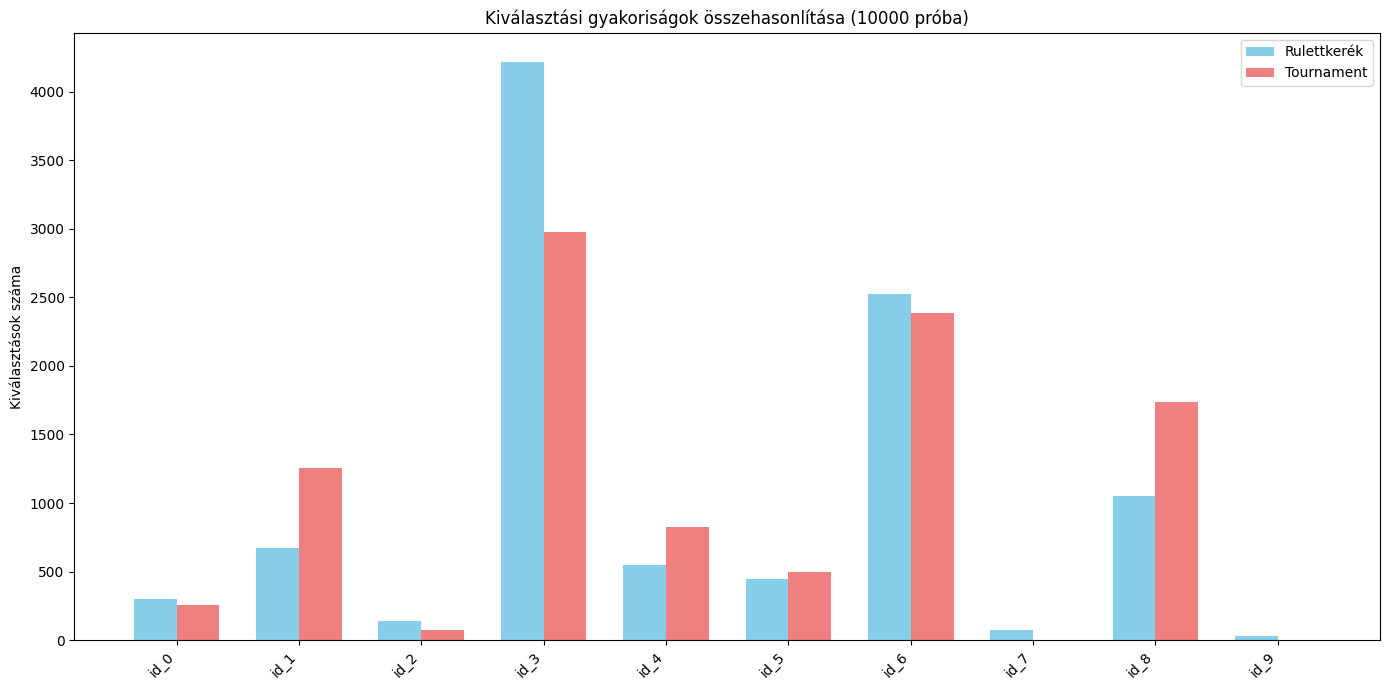

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

def normalize_positive(x):
    m = np.min(x)
    if m < 0:
        x = x - m
    return x

def plot_selection_counts(ids, counts, title):
    plt.figure()
    x = np.arange(len(ids))
    plt.bar(x, counts)
    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def roulette_wheel_selection(ids, fitness, n_select):
    f = normalize_positive(fitness.astype(float))
    total = np.sum(f)
    if total <= 0:
        p = np.ones_like(f) / len(f)
    else:
        p = f / total
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p

def tournament_selection(ids, fitness, n_select, k=4):
    chosen = []
    for _ in range(n_select):
        idxs = np.random.choice(len(ids), size=k, replace=False)
        best_idx = idxs[np.argmax(fitness[idxs])]
        chosen.append(ids[best_idx])
    return np.array(chosen)

def plot_combined_selection_counts(ids, counts_rw, counts_ts, title, label_rw="Rulettkerék", label_ts="Tournament"): # Modified to plot on one graph
    plt.figure(figsize=(14, 7))
    x = np.arange(len(ids))
    bar_width = 0.35

    plt.bar(x - bar_width/2, counts_rw, bar_width, label=label_rw, color='skyblue')
    plt.bar(x + bar_width/2, counts_ts, bar_width, label=label_ts, color='lightcoral')

    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

N = 10
ids = np.array([f"id_{i}" for i in range(N)])
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

n_trials = 10000

selected_rw, probs_rw = roulette_wheel_selection(ids, fitness, n_trials)
unique_rw, counts_rw = np.unique(selected_rw, return_counts=True)

count_map_rw = {u:c for u,c in zip(unique_rw, counts_rw)}
counts_ordered_rw = np.array([count_map_rw.get(i, 0) for i in ids])

print("Rulettkerék valószínűségek (elméleti):")
for i, id_ in enumerate(ids):
    print(f"{id_}: p={probs_rw[i]:.4f}")

k_tournament = 3
selected_ts = tournament_selection(ids, fitness, n_trials, k=k_tournament)
unique_ts, counts_ts = np.unique(selected_ts, return_counts=True)

count_map_ts = {u:c for u,c in zip(unique_ts, counts_ts)}
counts_ordered_ts = np.array([count_map_ts.get(i, 0) for i in ids])

plot_combined_selection_counts(
    ids,
    counts_ordered_rw,
    counts_ordered_ts,
    f"Kiválasztási gyakoriságok összehasonlítása ({n_trials} próba)"
)


**Koncentrálás a legjobbakra**: Képzeld el, hogy a rulettkerék szelekció (főleg az ind_3 a maga 41.8%-ával) az igazi sztárokra koncentrál, szinte csak őket akarja kiválasztani. Bezzeg a tournament szelekció (k=3), bár az is a jókat díjazza, de valahogy igazságosabban oszlatja el a "szavazatokat" a jobb egyedek között (pl. az ind_3 itt "csak" 29.4%-ot kapott, de az ind_8 vagy ind_1 relatíve többet, mint a rulettkeréknél).

**A gyengébbek esélye:** A rulettkeréknél még a gyengébb láncszemeknek is van némi esélyük, ha pozitív a fitnessük, még az ind_7 meg az ind_9 is kapott pár esélyt a 10 000 próbából. Na de a tournament szelekció (k=3)?! Ott a leggyengébbek (ind_7, ind_9) már nulla eséllyel indulnak, ez mutatja, hogy sokkal keményebb velük a rendszer.

**A szelekciós nyomás meg a diverzitás:** Összességében a tournament szelekció (k=3) erősebben nyomja a gyengébbeket, de közben a közepesen jóknak is ad esélyt a szuperzsenikkel szemben. Szóval jobban megőrzi a "sokszínűséget" a nem extrém egyedek között, mint a rulettkerék, ahol egyetlen kiugró egyed eltorzíthatja az egész kiválasztást.

**Robusztus dolog**: A tournament szelekció sokkal "strapabíróbb" az extrém fitness értékekkel szemben. Itt nem a nyers fitness számok arányán múlik a kiválasztás, hanem a versenyen, így egyetlen "űrbeli" jó egyed nem tudja annyira bedarálni az egész folyamatot, mint a rulettkeréknél.

## 5. Feladat (közepes) – Rang alapú szelekció paraméterérzékenysége

Egészítsd ki a laborkódot úgy, hogy:
1.   Legyen egy függvényed rank_based_selection(ids, fitness, N, s), ahol
- s = szelekciós nyomás (pl. 1.0–2.0 között),
- kiválasztási valószínűségek a rang alapján (pl. Baker-féle lineáris rangszelekció).
2.   Végezz kísérletet 10 000 kiválasztással:
- (a) s = 1.1
- (b) s = 1.9
3.   Hasonlítsd össze a kiválasztási gyakoriságokat: melyik s esetén erősebb a szelekciós nyomás?
4.   Fogalmazz meg 3 következtetést (pl. „nagy s esetén a gyenge egyedek szinte eltűnnek” stb.).

Valószínűségek (s=1.1, elméleti):
id_0: p=0.0967
id_1: p=0.1033
id_2: p=0.0944
id_3: p=0.1100
id_4: p=0.1011
id_5: p=0.0989
id_6: p=0.1078
id_7: p=0.0922
id_8: p=0.1056
id_9: p=0.0900

Valószínűségek (s=1.9, elméleti):
id_0: p=0.0700
id_1: p=0.1300
id_2: p=0.0500
id_3: p=0.1900
id_4: p=0.1100
id_5: p=0.0900
id_6: p=0.1700
id_7: p=0.0300
id_8: p=0.1500
id_9: p=0.0100


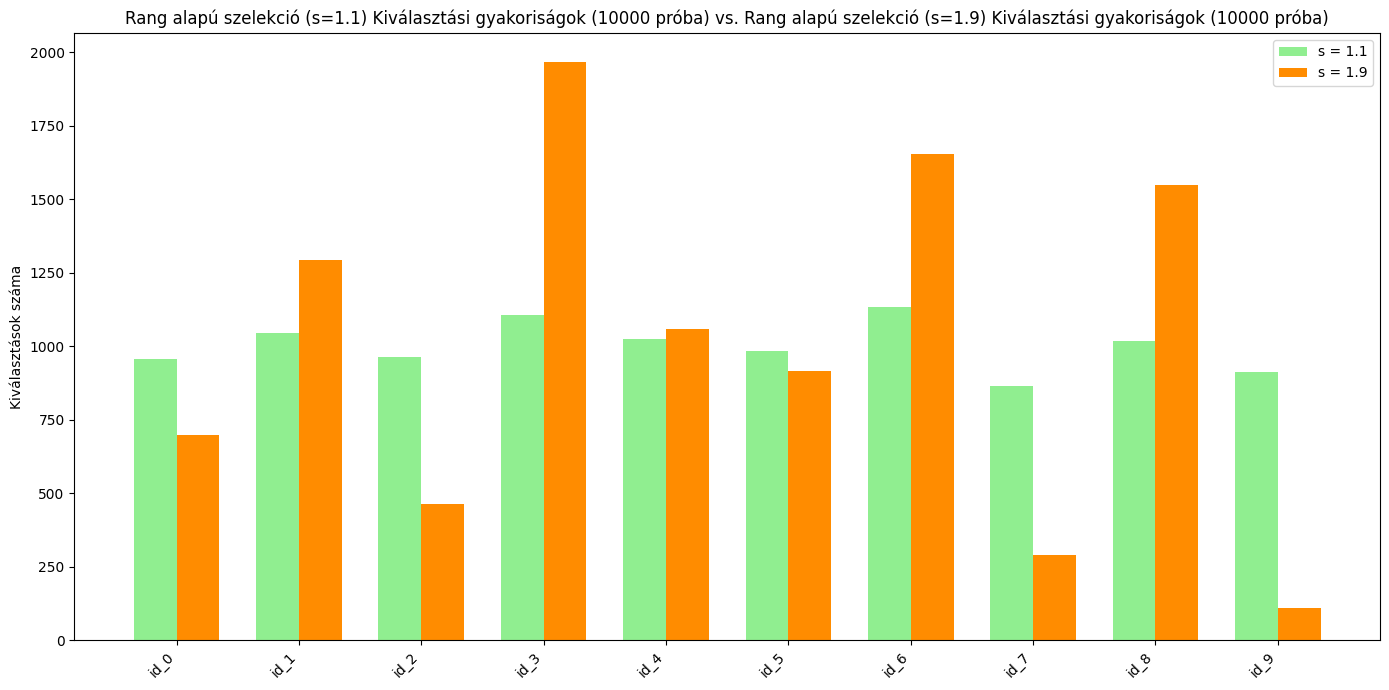

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_selection_counts(ids, counts, title):
    plt.figure()
    x = np.arange(len(ids))
    plt.bar(x, counts)
    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def rank_based_selection_s(ids, fitness, n_select, s):
    N = len(ids)

    order = np.argsort(-fitness)

    internal_rank = np.empty_like(order)
    internal_rank[order] = np.arange(N)

    probabilities = np.zeros(N)

    for i in range(N):
        probabilities[i] = ((2 - s) / N) + (2 * (s - 1) * (N - 1 - internal_rank[i])) / (N * (N - 1))

    probabilities = probabilities / np.sum(probabilities)

    chosen = np.random.choice(ids, size=n_select, replace=True, p=probabilities)
    return chosen, probabilities

def plot_combined_selection_counts(ids, counts1, title1, counts2, title2, label1="S=1.1", label2="S=1.9"):
    plt.figure(figsize=(14, 7))
    x = np.arange(len(ids))
    bar_width = 0.35

    plt.bar(x - bar_width/2, counts1, bar_width, label=label1, color='lightgreen')
    plt.bar(x + bar_width/2, counts2, bar_width, label=label2, color='darkorange')

    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(f"{title1} vs. {title2}")
    plt.legend()
    plt.tight_layout()
    plt.show()

N = 10
ids = np.array([f"id_{i}" for i in range(N)])
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

n_trials = 10000

selected_s1_1, probs_s1_1 = rank_based_selection_s(ids, fitness, n_trials, s=1.1)
unique_s1_1, counts_s1_1 = np.unique(selected_s1_1, return_counts=True)
count_map_s1_1 = {u:c for u,c in zip(unique_s1_1, counts_s1_1)}
counts_ordered_s1_1 = np.array([count_map_s1_1.get(i, 0) for i in ids])

print("Valószínűségek (s=1.1, elméleti):")
for i, id_ in enumerate(ids):
    print(f"{id_}: p={probs_s1_1[i]:.4f}")

selected_s1_9, probs_s1_9 = rank_based_selection_s(ids, fitness, n_trials, s=1.9)
unique_s1_9, counts_s1_9 = np.unique(selected_s1_9, return_counts=True)
count_map_s1_9 = {u:c for u,c in zip(unique_s1_9, counts_s1_9)}
counts_ordered_s1_9 = np.array([count_map_s1_9.get(i, 0) for i in ids])

print("\nValószínűségek (s=1.9, elméleti):")
for i, id_ in enumerate(ids):
    print(f"{id_}: p={probs_s1_9[i]:.4f}")

plot_combined_selection_counts(
    ids,
    counts_ordered_s1_1,
    f"Rang alapú szelekció (s=1.1) Kiválasztási gyakoriságok ({n_trials} próba)",
    counts_ordered_s1_9,
    f"Rang alapú szelekció (s=1.9) Kiválasztási gyakoriságok ({n_trials} próba)",
    label1="s = 1.1",
    label2="s = 1.9"
)

1. **Szelekciós nyomás koncentrációja**: Minél nagyobb az s értéke, annál erősebb a szelekciós nyomás, és annál inkább koncentrálódik a kiválasztás a legmagasabb fitnesszű egyedekre. Az s = 1.9 esetben a legjobb egyedek kiválasztási gyakorisága sokkal magasabb, mint s = 1.1 esetén.

2. **Gyengébb egyedek esélye**: Egy alacsonyabb s (pl. s = 1.1) több esélyt ad a közepes és gyengébb egyedeknek is a kiválasztásra, ezzel növelve a diverzitást. Ezzel szemben egy magasabb s (pl. s = 1.9) drasztikusan csökkenti, vagy teljesen megszünteti a leggyengébb egyedek kiválasztási esélyét.

3. **Diverzitás és konvergencia:** A magasabb s érték gyorsabb konvergenciához vezethet a jobb megoldások felé, de növeli a lokális optimumokba való beszorulás kockázatát a diverzitás gyors csökkenése miatt. Egy alacsonyabb s érték lassabb, de robusztusabb feltárást tesz lehetővé a keresési térben.

## 6. Feladat (közepes) – Elitizmus hatása a diverzitásra
Használd a jegyzetben lévő next_generation_with_elite ötletét:
1.   Készíts egy szimulációt, ahol:
- Populációméret = 10
- Elit méret E = 0, E = 2, E = 5
- Új generáció többi részét mondjuk rang alapú szelekcióval töltöd fel.
2.   Egy egyszerű GA-keretben (pl. 20 generáció, csak szelekció + „dummy” fitness frissítés nélkül) nézd meg:
- Hány különböző egyed marad a populációban (diverzitás) az idő előrehaladtával?
3.   Írj 5–6 mondatot arról, hogyan hat az elitizmus mértéke a diverzitásra és a „beszorulás” kockázatára.

Elitizmus hatásának szimulációja a diverzitásra:
~ Elit méret E = 0
Utolsó generáció diverzitása (E=0): 1
~ Elit méret E = 2
Utolsó generáció diverzitása (E=2): 1
~ Elit méret E = 5
Utolsó generáció diverzitása (E=5): 1


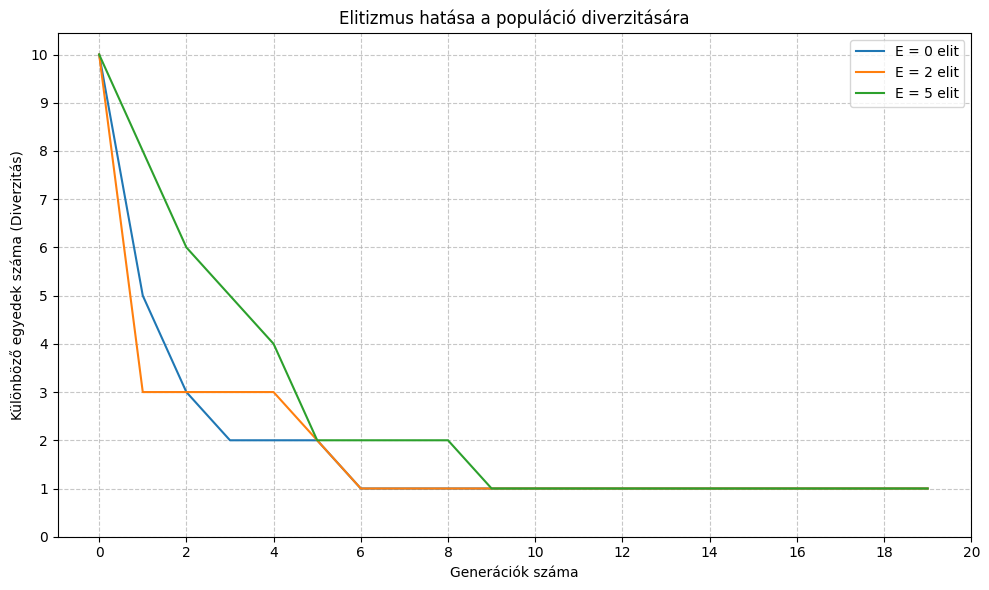

In [19]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
ids = np.array([f"id_{i}" for i in range(N)])
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

def calculate_diversity(population_ids):
    return len(np.unique(population_ids))

def elite_preservation(ids, fitness, E):
    order = np.argsort(-fitness)
    elites = ids[order[:E]]
    return elites

def rank_based_selection(ids, fitness, n_select):
    order = np.argsort(-fitness) # desc
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(len(ids), 0, -1)

    p = ranks / np.sum(ranks)
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p, ranks

def next_generation_with_elite(current_population_ids, current_fitness, pop_size, E):
    elites = elite_preservation(current_population_ids, current_fitness, E=E)
    remaining = pop_size - E

    if remaining > 0:
        selected_from_rank, _, _ = rank_based_selection(current_population_ids, current_fitness, remaining)
        new_gen = np.concatenate([elites, selected_from_rank])
    else:
        new_gen = elites[:pop_size]

    return new_gen

pop_size = 10
generations = 20
elite_sizes = [0, 2, 5]

diversity_histories = {}

print("Elitizmus hatásának szimulációja a diverzitásra:")

for E in elite_sizes:
    print(f"~ Elit méret E = {E}")
    current_population_ids = np.copy(ids)
    history = []

    for gen in range(generations):
        diversity = calculate_diversity(current_population_ids)
        history.append(diversity)
        current_population_ids = next_generation_with_elite(current_population_ids, fitness, pop_size, E)

    diversity_histories[E] = history
    print(f"Utolsó generáció diverzitása (E={E}): {history[-1]}")

plt.figure(figsize=(10, 6))
for E, history in diversity_histories.items():
    plt.plot(range(generations), history, label=f'E = {E} elit')

plt.xlabel("Generációk száma")
plt.ylabel("Különböző egyedek száma (Diverzitás)")
plt.title("Elitizmus hatása a populáció diverzitására")
plt.xticks(np.arange(0, generations + 1, 2))
plt.yticks(np.arange(0, pop_size + 1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Az elitizmus azt jelenti, hogy a legjobb egyedek fixen átjutnak a következő generációba, így garantálva, hogy a populáció fitnessze csak jobb vagy ugyanolyan marad. De az elitizmus mértéke nagyon fontos a diverzitás (sokszínűség) szempontjából.

Ha túl sok elit van (pl. E=5), az nagyon gyorsan csökkenti a populáció diverzitását, mert alig marad hely az új, mást képviselő egyedeknek, és a populáció gyorsan ugyanolyan lesz a legjobb(ak) körül. Ez a gyors "összeolvadás" viszont növeli annak a kockázatát, hogy beleragadunk egy rosszabb, helyi optimumba, mert a korai legjobb megoldások túl dominánssá válnak, és megakadályozzák, hogy valami még jobbat találjunk.

Ezzel szemben a mérsékelt elitizmus (pl. E=2) segít egy jó egyensúlyt tartani a gyors fejlődés és a sokszínűség megőrzése között. Az elitizmus hiánya (E=0) pedig lassabb, de sokszínűbb fejlődést eredményezhet, bár ilyenkor benne van a pakliban, hogy a már megtalált legjobb megoldást elveszítjük.

## 7. Feladat (nehéz) – Boltzmann-szelekció és hőmérséklet ütemezés
Készíts egy saját Boltzmann-szelekció modult, a jegyzetben lévő softmax_scaled függvényt felhasználva:

1.   Definiálj hőmérséklet-idő függvényt:
- (a) Lassú hűtés: T(t) = 5 / (1 + 0.05 * t)
- (b) Gyors hűtés: T(t) = 5 / (1 + 0.5 * t),
- ahol t a generáció sorszáma (0…50).
2.   Egy egyszerű GA-keretben, fix fitness-szel (a laborminta-populáció), 50 generáción át:
- minden generációban számold ki a Boltzmann-alapú kiválasztási valószínűségeket az aktuális T(t) mellett,
- végezz 10 kiválasztást (új populáció).
3.   Mérd minden generációnál:
- a legjobb egyed várható fitnessét (pl. populációmax),
- és a diverzitást (különböző egyedek száma, vagy Shannon-entrópia a gyakoriságokból).
4.   Hasonlítsd össze a lassú és gyors hűtést:
- Melyik esetben „hűl be” gyorsabban a rendszer (csökken a diverzitás)?
- Melyik esetben jobb a végső (50. generációs) legjobb fitness?
5.   Fogalmazz meg rövid szakmai következtetést: mikor lehet hasznos a Boltzmann-szelekció, és hogyan kell óvatosan megválasztani a hőmérséklet ütemezést?


Lassú hűtés
Utolsó generáció legjobb fitness (lassú hűtés): 30.00

Gyors hűtés
Utolsó generáció legjobb fitness (gyors hűtés): 30.00


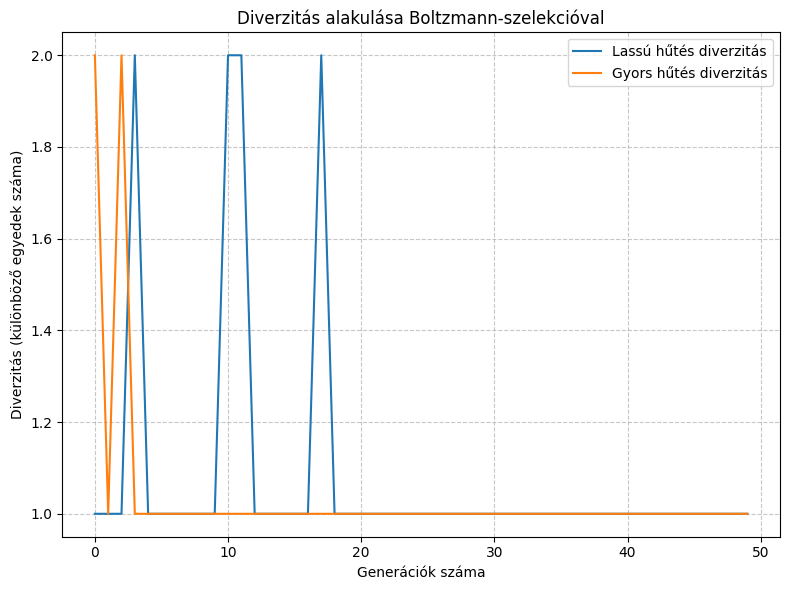

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random

def softmax_scaled(x, T=1.0):
    z = (x - np.max(x)) / max(T, 1e-8)
    e = np.exp(z)
    return e / np.sum(e)

def calculate_diversity(population_ids):
    return len(np.unique(population_ids))

def slow_cooling(t):
    return 5 / (1 + 0.05 * t)

def fast_cooling(t):
    return 5 / (1 + 0.5 * t)

N = 10
ids = np.array([f"id_{i}" for i in range(N)])
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

generations = 50
pop_size = 10
selection_count_per_gen = 10

diversity_slow = []
best_fitness_slow = []

diversity_fast = []
best_fitness_fast = []

print("\nLassú hűtés")
current_population_ids_slow = np.copy(ids)
for t in range(generations):
    T_val = slow_cooling(t)

    probs = softmax_scaled(fitness, T=T_val)

    chosen_ids = np.random.choice(ids, size=selection_count_per_gen, replace=True, p=probs)

    current_population_ids_slow = chosen_ids

    diversity_slow.append(calculate_diversity(current_population_ids_slow))
    best_fitness_slow.append(np.max(fitness[np.isin(ids, current_population_ids_slow)]))

print(f"Utolsó generáció legjobb fitness (lassú hűtés): {best_fitness_slow[-1]:.2f}")

print("\nGyors hűtés")
current_population_ids_fast = np.copy(ids)
for t in range(generations):
    T_val = fast_cooling(t)

    probs = softmax_scaled(fitness, T=T_val)

    chosen_ids = np.random.choice(ids, size=selection_count_per_gen, replace=True, p=probs)

    current_population_ids_fast = chosen_ids

    diversity_fast.append(calculate_diversity(current_population_ids_fast))
    best_fitness_fast.append(np.max(fitness[np.isin(ids, current_population_ids_fast)]))

print(f"Utolsó generáció legjobb fitness (gyors hűtés): {best_fitness_fast[-1]:.2f}")

plt.figure(figsize=(8, 6))

plt.plot(range(generations), diversity_slow, label='Lassú hűtés diverzitás')
plt.plot(range(generations), diversity_fast, label='Gyors hűtés diverzitás')
plt.xlabel("Generációk száma")
plt.ylabel("Diverzitás (különböző egyedek száma)")
plt.title("Diverzitás alakulása Boltzmann-szelekcióval")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

**A rendszer 'lehűlése' (vagyis a sokszínűség csökkenése)**:

* Ha gyorsan lehűl a rendszer (mint egy kávé, amit azonnal megiszol), akkor a diverzitás (vagyis a sokszínűség) iszonyat gyorsan lezuhan. Olyan, mintha a buliban mindenki hirtelen egyforma zenére akarna táncolni, és csak a legmenőbb arcok maradnak a parketten. Hamar egyféle lesz az egész, és csak a legerősebbek számítanak.

* De ha lassan hűl (mint az a kávé, ami órákig langyos marad), akkor sokkal tovább megmarad a változatosság. Több idő van 'körülnézni', más dolgokat is kipróbálni, nem nyomja el azonnal az 1-2 'sztár' a többieket. Ez segít abban, hogy több mindent felfedezzünk.

**Végső (50. generációs) legjobb fitness**:

* Na és mi lesz a végeredmény? A lassú hűtésnél gyakran jobb végső megoldást találunk, mert volt időnk alaposabban körbenézni, és nem ragadtunk bele valami 'elég jóba'. Nagyobb eséllyel lesz ez a legeslegjobb.

* A gyors hűtésnél meg lehet, hogy hamar találunk valamit, de az nem biztos, hogy a tökéletes, csak egy 'majdnem jó' megoldás, mert hirtelen bezárult a kör, és már nem kerestünk tovább.

###Ami ebből a tanulság:

A Boltzmann-szelekcióval ügyesen el tudod játszani, hogy az elején még mindent kipróbálsz, aztán ahogy telik az idő, egyre pontosabban ráállsz a tuti dolgokra. De a hőmérsékletet nagyon be kell lőni!

* Ha túl gyorsan hűl (mint egy gyors ítélet), akkor hamar 'befagy' az agy, és lehet, hogy csak egy 'majdnem jó' megoldásnál állunk meg, mert nem volt időnk rendesen gondolkodni. Körülnézhetsz egy helyen, de aztán leragadsz.

* Ha meg túl lassan (mint egy végtelen agyalás), akkor meg tök lassan találjuk meg a jót, ha egyáltalán. Ilyenkor meg túl sok az a sokszínűség, ami nem vezet célra.

Szóval a trükk az, hogy megtaláld a középútat aközött, hogy mikor 'fedezzünk fel' új dolgokat (ezt hívjuk 'explorationnek'), és mikor 'használjuk ki' már a beváltakat (ez meg az 'exploitation').